In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown
import numpy as np

In [56]:
df_raw = pd.read_csv("raw_results.csv")
df_hybrid = pd.read_csv("hybrid_results.csv")

Now display the raw results from model testing for the hybrid model, with the coloumns seen below that.

In [58]:
display(df_hybrid.head(3))
display(df_hybrid.columns.tolist())

,instruction,expected_output,model_output,similar_problem_1,similar_solution_1,urgency_1,category_1,similarity_1,similar_problem_2,similar_solution_2,...,pred_category,pred_resolution,TICKETID,CLEAN_PROBLEM,true_urgency_code,true_category,true_resolution,fuzzy_ratio,resolution_embedding_similarity,avg_retriever_similarity
0,Classify and resolve this support ticket using...,- Urgency: 3\n- Category: S1000v4\n- Solution:...,"{""Urgency Code"": ""3"", ""Category"": ""S1000v4"", ""...","The user is experiencing issues with Sage, spe...",The issue was resolved by identifying and clos...,3,S1000v4,0.705026,Sage is not functioning correctly. \n\n- The E...,The issue was investigated and a solution was ...,...,S1000v4,The issue was resolved by restarting the serve...,t6UJ9A00FYRB,Users are experiencing issues running Sage EDI...,3,S1000v4,"A previous issue was raised by the customer, a...",61,0.433594,0.671014
1,Classify and resolve this support ticket using...,- Urgency: 3\n- Category: S1000v4\n- Solution:...,"{""Urgency Code"": ""3"", ""Category"": ""S1000v3"", ""...","A batch has become locked, preventing further ...",The issue was resolved after several attempts....,3,S1000v3,0.636257,A batch process has become stuck and we need t...,"The IT team identified the issue as a user, dp...",...,S1000v3,The issue was resolved by identifying the root...,t6UJ9A00G06Y,"SL batches appear to be stuck, indicating that...",3,S1000v4,The support team used TeamViewer to investigat...,49,0.471532,0.628856
2,Classify and resolve this support ticket using...,- Urgency: 3\n- Category: S1000v4\n- Solution:...,"{""Urgency Code"": ""3"", ""Category"": ""S1000v4"", ""...",The user is experiencing a system freeze durin...,The support team was unable to connect to the ...,3,S1000v4,0.581464,The user is unable to exit or progress from a ...,The support team connected to the server to tr...,...,S1000v4,The issue was resolved by restarting the compu...,t6UJ9A00F3Q9,The computer restarted while running certain p...,3,S1000v4,The issue was resolved after the customer repo...,60,0.558948,0.574568


['instruction',
 'expected_output',
 'model_output',
 'similar_problem_1',
 'similar_solution_1',
 'urgency_1',
 'category_1',
 'similarity_1',
 'similar_problem_2',
 'similar_solution_2',
 'urgency_2',
 'category_2',
 'similarity_2',
 'similar_problem_3',
 'similar_solution_3',
 'urgency_3',
 'category_3',
 'similarity_3',
 'avg_similarity',
 'ticketID',
 'pred_urgency_code',
 'pred_category',
 'pred_resolution',
 'TICKETID',
 'CLEAN_PROBLEM',
 'true_urgency_code',
 'true_category',
 'true_resolution',
 'fuzzy_ratio',
 'resolution_embedding_similarity',
 'avg_retriever_similarity']

Now find average fuzzy and embeded similarity 

In [78]:
# Calculate averages
raw_summary = pd.DataFrame({
    "Retriever": ["Raw"],
    "Avg Retriver Similarity": [df_raw["resolution_embedding_similarity"].mean()],
    "Avg Fuzzy Ratio": [df_raw["fuzzy_ratio"].mean()]
})

hybrid_summary = pd.DataFrame({
    "Retriever": ["Hybrid"],
    "Avg Retriver Similarity": [df_hybrid["resolution_embedding_similarity"].mean()],
    "Avg Fuzzy Ratio": [df_hybrid["fuzzy_ratio"].mean()]
})

# Combine and display
summary_df = pd.concat([raw_summary, hybrid_summary], ignore_index=True)
display(summary_df)

,Retriever,Avg Retriver Similarity,Avg Fuzzy Ratio
0,Raw,0.466350,44.038911
1,Hybrid,0.480741,51.135659


📊 Accuracy Summary:


,Metric,Score
0,Raw - Urgency Accuracy,0.894942
1,Raw - Category Accuracy,0.736434
2,Raw - Overall Accuracy,0.647287


,Metric,Score
0,Hybrid - Urgency Accuracy,0.910853
1,Hybrid - Category Accuracy,0.744186
2,Hybrid - Overall Accuracy,0.670543


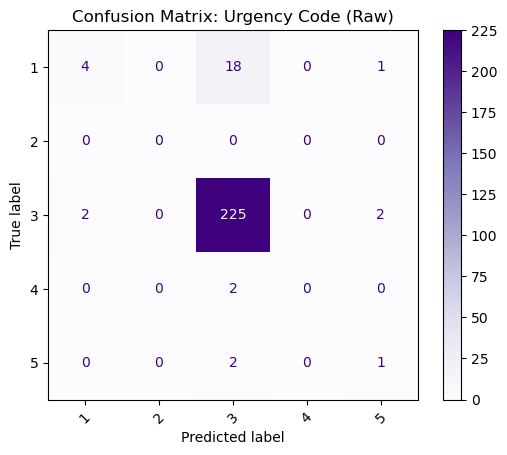

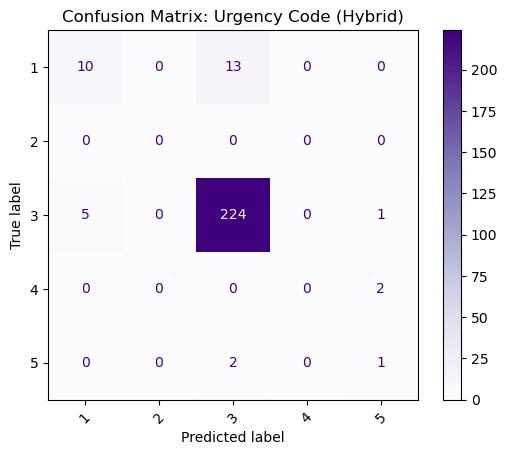

In [62]:
# === Preprocess true/pred columns ===
for df in [df_raw, df_hybrid]:
    # Convert urgency codes to integers
    df["true_urgency_code"] = pd.to_numeric(df["true_urgency_code"], errors="coerce").astype("Int64")
    df["pred_urgency_code"] = pd.to_numeric(df["pred_urgency_code"], errors="coerce").astype("Int64")

    # Normalize category text
    df["true_category"] = df["true_category"].astype(str).str.lower().str.strip()
    df["pred_category"] = df["pred_category"].astype(str).str.lower().str.strip()

    # Compute correctness flags
    df["correct_urgency"] = df["true_urgency_code"] == df["pred_urgency_code"]
    df["correct_category"] = df["true_category"] == df["pred_category"]
    df["correct_overall"] = df["correct_urgency"] & df["correct_category"]

# === Accuracy summary function ===
def accuracy_summary(df, name):
    return pd.DataFrame({
        "Metric": [f"{name} - Urgency Accuracy", f"{name} - Category Accuracy", f"{name} - Overall Accuracy"],
        "Score": [
            df["correct_urgency"].mean(),
            df["correct_category"].mean(),
            df["correct_overall"].mean()
        ]
    })

# === Display Accuracy Summary ===
print("📊 Accuracy Summary:")
display(accuracy_summary(df_raw, "Raw"))
display(accuracy_summary(df_hybrid, "Hybrid"))

# === Plot Confusion Matrix ===
def plot_confusion(df, title):
    urgency_labels = [1, 2, 3, 4, 5]

    # Drop rows with missing urgency codes
    df_valid = df.dropna(subset=["true_urgency_code", "pred_urgency_code"])

    cm = confusion_matrix(df_valid["true_urgency_code"], df_valid["pred_urgency_code"], labels=urgency_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=urgency_labels)
    disp.plot(cmap="Purples")
    plt.title(f"Confusion Matrix: Urgency Code ({title})")
    plt.xticks(rotation=45)
    plt.show()

# Plot for both raw and hybrid
plot_confusion(df_raw, "Raw")
plot_confusion(df_hybrid, "Hybrid")


Now investigate models performance on tickets with highley correalting similar solutions and ones with low correalting solutions.

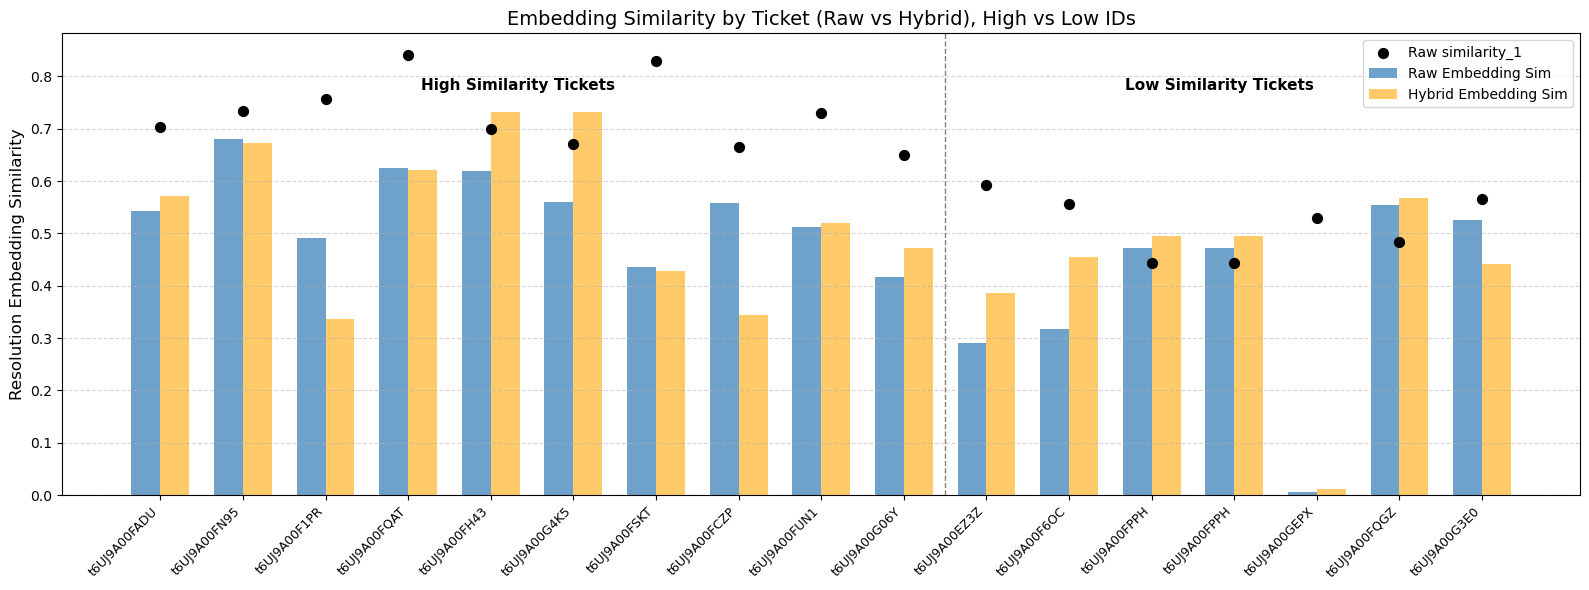

In [64]:
high_ids = [
    "t6UJ9A00FADU", "t6UJ9A00FN95", "t6UJ9A00F1PR", "t6UJ9A00FQAT", "t6UJ9A00FH43",
    "t6UJ9A00G4K5", "t6UJ9A00FSKT", "t6UJ9A00FCZP", "t6UJ9A00FUN1", "t6UJ9A00G06Y"
]
low_ids = [
    "t6UJ9A00EZ3Z", "t6UJ9A00F6OC", "t6UJ9A00FPPH", "t6UJ9A00FPPH", "t6UJ9A00GEPX",
    "t6UJ9A00FQGZ", "t6UJ9A00G3E0"
]

#Combine the IDs of interest
selected_ids = high_ids + low_ids

#function to extract similarity values for those IDs
def get_values(df, ticket_ids, sim_col="resolution_embedding_similarity", sim1_col="similarity_1"):
    df2 = df[df['ticketID'].astype(str).isin(ticket_ids)]
    df2 = df2.set_index('ticketID')
    sim_vals = df2[sim_col].reindex(ticket_ids).to_list()  # reindex to preserve order
    sim1_vals = df2[sim1_col].reindex(ticket_ids).to_list() if sim1_col in df2.columns else [None]*len(ticket_ids)
    return sim_vals, sim1_vals
raw_vals, raw_sim1 = get_values(df_raw, selected_ids)
hybrid_vals, hybrid_sim1 = get_values(df_hybrid, selected_ids)
fig, ax = plt.subplots(figsize=(16,6))
x = list(range(len(selected_ids)))
width = 0.35
ax.bar(x, raw_vals, width=width, label="Raw Embedding Sim", color='#4B8BBE', alpha=0.8)
ax.bar([i + width for i in x], hybrid_vals, width=width, label="Hybrid Embedding Sim", color='#FFBD44', alpha=0.8)
ax.scatter([i + width/2 for i in x], raw_sim1, color='black', marker='o', label="Raw similarity_1", s=50, zorder=5)

#Now plotting
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(selected_ids, rotation=45, ha='right', fontsize=9)


ax.set_ylabel("Resolution Embedding Similarity", fontsize=12)
ax.set_title("Embedding Similarity by Ticket (Raw vs Hybrid), High vs Low IDs", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.5)


sep_pos = len(high_ids) - 0.5
ax.axvline(x=sep_pos + width/2, color='gray', linestyle='--', linewidth=1)


top = max(max(raw_vals or [0]), max(hybrid_vals or [0])) * 1.05
ax.text((len(high_ids)-1)/2, top, 'High Similarity Tickets', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.text(len(high_ids) + (len(low_ids)-1)/2, top, 'Low Similarity Tickets', ha='center', va='bottom', fontsize=11, fontweight='bold')


ax.legend()
plt.tight_layout()
plt.show()

Further investigating, this high performance with similar tickets. Found that alot more "True" solutions produced by hybrid model 

In [146]:
fuzzy_threshold = 75

# Compute percentages for fuzzy ratio
fuzzy_raw = (df_raw["fuzzy_ratio"] > fuzzy_threshold).mean() * 100
fuzzy_hybrid = (df_hybrid["fuzzy_ratio"] > fuzzy_threshold).mean() * 100

# Display results
fuzzy_summary = pd.DataFrame({
    "Model": ["Raw", "Hybrid"],
    f"Fuzzy > {fuzzy_threshold} (%)": [fuzzy_raw, fuzzy_hybrid]
})

from IPython.display import display, Markdown
display(Markdown(f"### Percentage of Tickets with Fuzzy Match > {fuzzy_threshold}"))
display(fuzzy_summary.round(2))

### Percentage of Tickets with Fuzzy Match > 75

,Model,Fuzzy > 75 (%)
0,Raw,1.94
1,Hybrid,7.75


In [148]:
import seaborn as sns
from scipy.stats import pearsonr

Now want to investigate the success of the retiver, to do this a fuzzy ratio of solution was plotted against the similarity of most relevant case. 

📈 Pearson Correlation (avg_retriever_similarity vs fuzzy_ratio): 0.1895
📊 P-value: 2.2823e-03


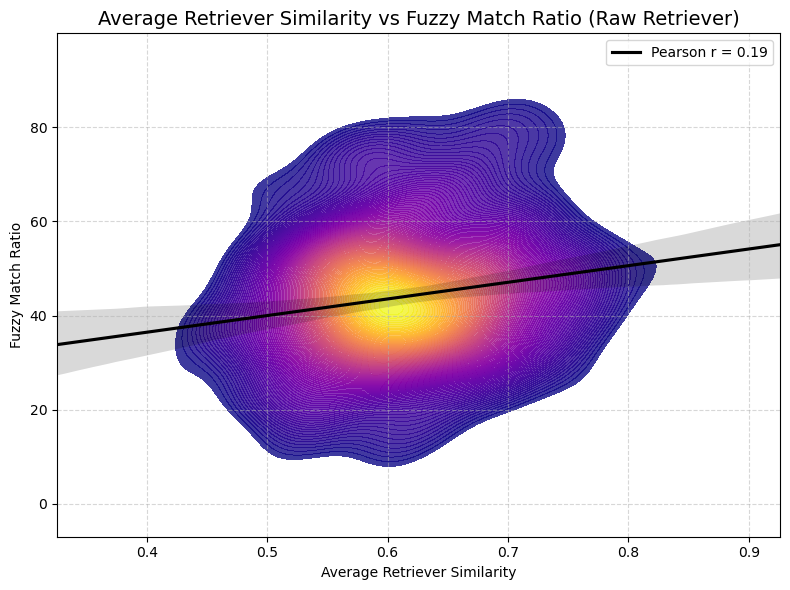

In [150]:
def plot_kde_reg(df, x_col, y_col, title, x_label, y_label):
    # Clean NaNs
    df_clean = df.dropna(subset=[x_col, y_col])

    # Compute Pearson correlation
    r, p = pearsonr(df_clean[x_col], df_clean[y_col])
    print(f"📈 Pearson Correlation ({x_col} vs {y_col}): {r:.4f}")
    print(f"📊 P-value: {p:.4e}")

    # Plot
    plt.figure(figsize=(8, 6))

    # KDE background
    sns.kdeplot(
        data=df_clean,
        x=x_col,
        y=y_col,
        fill=True,
        cmap="plasma",
        thresh=0.05,
        levels=100,
        alpha=0.8
    )

    # Regression line
    sns.regplot(
        data=df_clean,
        x=x_col,
        y=y_col,
        scatter=False,
        color="black",
        truncate=False,
        label=f"Pearson r = {r:.2f}"
    )

    # Labels and formatting
    plt.title(title, fontsize=14)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Use the raw model's data
plot_kde_reg(
    df=df_raw,
    x_col="avg_retriever_similarity",
    y_col="fuzzy_ratio",
    title="Average Retriever Similarity vs Fuzzy Match Ratio (Raw Retriever)",
    x_label="Average Retriever Similarity",
    y_label="Fuzzy Match Ratio"
)

Now giving a Web Chart to compare how the raw Llama3 model with no fine tuning, 

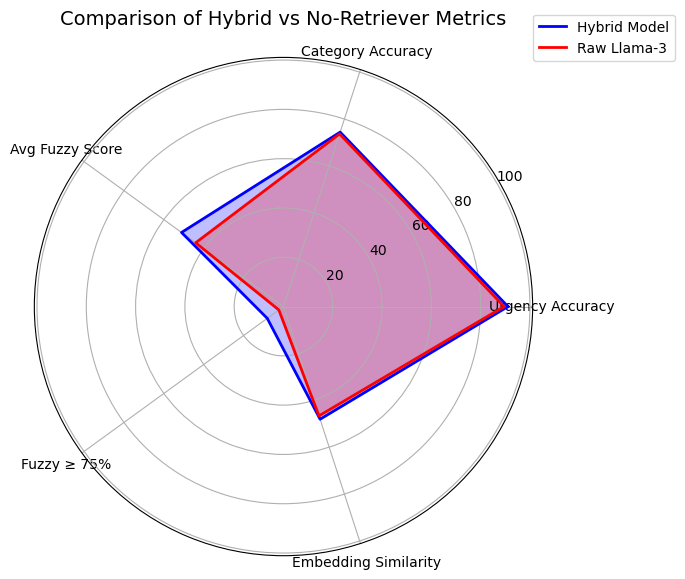

In [76]:
hyb_urgency_acc = (df_hybrid["true_urgency_code"] == df_hybrid["pred_urgency_code"]).mean() * 100
hyb_category_acc = (df_hybrid["true_category"] == df_hybrid["pred_category"]).mean() * 100
hyb_fuzzy_score = df_hybrid["fuzzy_ratio"].dropna().mean()
hyb_fuzzy_over_75 = (df_hybrid["fuzzy_ratio"].dropna() >= 75).mean() * 100
hyb_emb_sim = df_hybrid["resolution_embedding_similarity"].dropna().mean() * 100

# === Extract metrics from raw DataFrame ===
raw_urgency_acc = (df_raw["true_urgency_code"] == df_raw["pred_urgency_code"]).mean() * 100
raw_category_acc = (df_raw["true_category"] == df_raw["pred_category"]).mean() * 100
raw_fuzzy_score = df_raw["fuzzy_ratio"].dropna().mean()
raw_fuzzy_over_75 = (df_raw["fuzzy_ratio"].dropna() >= 75).mean() * 100
raw_emb_sim = df_raw["resolution_embedding_similarity"].dropna().mean() * 100

# === Prepare for plotting ===
labels = [
    "Urgency Accuracy",
    "Category Accuracy",
    "Avg Fuzzy Score",
    "Fuzzy ≥ 75%",
    "Embedding Similarity"
]

hybrid_vals = [
    hyb_urgency_acc,
    hyb_category_acc,
    hyb_fuzzy_score,
    hyb_fuzzy_over_75,
    hyb_emb_sim
]

raw_vals = [
    raw_urgency_acc,
    raw_category_acc,
    raw_fuzzy_score,
    raw_fuzzy_over_75,
    raw_emb_sim
]

# Close the loop
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
hybrid_vals += hybrid_vals[:1]
raw_vals += raw_vals[:1]

# === Radar Chart ===
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], labels, color='black', size=10)

# Draw the two polygons
ax.plot(angles, hybrid_vals, color='blue', linewidth=2, label='Hybrid Model')
ax.fill(angles, hybrid_vals, color='blue', alpha=0.25)

ax.plot(angles, raw_vals, color='red', linewidth=2, label='Raw Llama-3')
ax.fill(angles, raw_vals, color='red', alpha=0.25)

# Radial settings
ax.set_rlabel_position(30)
max_val = max(max(hybrid_vals), max(raw_vals))
ax.set_ylim(0, max_val + 10)

# Title and legend
plt.title("Comparison of Hybrid vs No‑Retriever Metrics", size=14, y=1.05)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()